In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams["figure.dpi"] = 150
import ipywidgets as widgets
from particle import PDGID

In [2]:
data = pd.read_csv('sig_hits.txt', sep=' ')
data.head()

,phi,theta,x,y,pt,pid,phi0,prodx,prody,prodz
0,-1.96812,0.80937,-11.68519,-27.81020,36.00956,13,-1.96902,0.0,-0.0,0.0
1,-0.83047,1.05909,20.35797,-22.30179,34.14070,13,-0.83141,0.0,0.0,0.0
2,1.36624,2.40121,6.25001,30.06152,34.26291,13,1.36530,-0.0,0.0,0.0
3,0.08748,2.06299,30.16500,2.63672,54.29924,13,0.08689,-0.0,0.0,0.0
4,1.52425,1.26671,1.39946,30.16500,89.56950,-13,1.52462,-0.0,0.0,0.0


In [3]:
X = data['x']
Y = data['y']
Phi = data['phi']
Theta = data['theta']
PT = data['pt']
PID = data['pid']

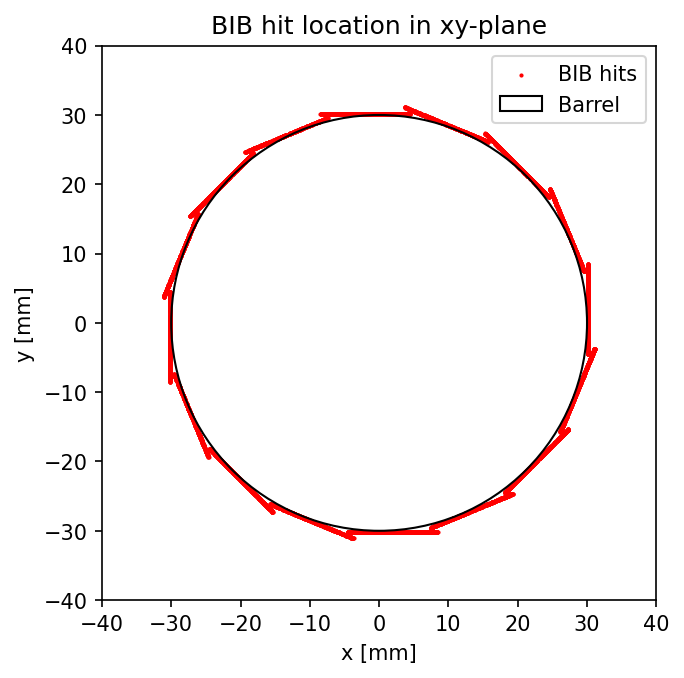

In [4]:
fig,ax=plt.subplots()
ax.scatter(data['x'],data['y'],s=1, c='r', label="BIB hits")
plt.gca().set_aspect('equal')
circle=plt.Circle((0,0), 30, fill=0, color='k', label="Barrel")
ax.add_patch(circle)
ax.set_title("BIB hit location in xy-plane")
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.legend(loc="upper right")
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
plt.show()

In [5]:
sensorAngles = np.arange(-np.pi,np.pi+2*np.pi/8,np.pi/8)

def getYlocalAndGamma(x,y):
    # Get gamma of the point
    gammaP=np.arctan2(y,x)

    # Get two sensor angles that are closest to gammaP

    diff = np.abs(sensorAngles-gammaP)
    index1 = np.argmin(diff)
    gamma1=sensorAngles[index1]

    diff[index1]=3*np.pi
    index2 = np.argmin(diff)
    gamma2=sensorAngles[index2]

    # Rotate x coordinate of the point by each option for gamma
    x1=x*np.cos(-gamma1)-y*np.sin(-gamma1)
    y1=y*np.cos(-gamma1)+x*np.sin(-gamma1)
    x2=x*np.cos(-gamma2)-y*np.sin(-gamma2)
    y2=y*np.cos(-gamma2)+x*np.sin(-gamma2)

    # Determine which x is closest to expected value
    xTrue=30.16475324197002

    diff1=abs(x1-xTrue)
    diff2=abs(x2-xTrue)
    
    # If both x1 and x2 are really close to the ex
    if diff1 < 0.5 and diff2 < 0.5:
        if y1>8.5 or y1<-4.5:
            index=index2
        else:
            index=index1
            
    elif diff1<diff2:
        index=index1
    else:
        index=index2

    if index==index1:
        yentry=y1
    else:
        yentry=y2
    
    ylocal=yentry+12.5*13/2/1000
    
    if index==0:
        index=16
    if index==17:
        index=1
    
    #gamma=sensorAngles[index]

    return -ylocal, index


In [6]:
yLocal = []
Index = []
Vec0 = []
Vec1 = []
Beta = []
Q = []
for x,y,phi,theta,pid in zip(data['x'],data['y'],data['phi'],data['theta'],data['pid']):
    ylocal, index = getYlocalAndGamma(x,y)
    yLocal.append(ylocal)
    Index.append(index)
    gamma = sensorAngles[index]
    #if gamma < 0: gamma+=2*np.pi
    x0=np.cos(phi)
    y0=np.sin(phi)

    Vec0.append((x0,y0))

    # Transform into rotated coordinate system (sensor coordinate system sort of)
    #xp=x0*np.cos(np.pi/2-gamma)-y0*np.sin(np.pi/2-gamma)
    #yp=x0*np.sin(np.pi/2-gamma)+y0*np.cos(np.pi/2-gamma)
    beta = phi-(gamma-np.pi/2)

    if beta < -np.pi:
        beta += 2*np.pi
    if beta > np.pi:
        beta -= 2*np.pi

    xp=np.cos(beta)
    yp=np.sin(beta)
    
    Beta.append(beta)

    Vec1.append((xp,yp))

    Q.append(PDGID(pid).charge)

data['ylocal'] = yLocal
data['index'] = Index
data['vec0'] = Vec0
data['vec1'] = Vec1
data['beta'] = Beta
data['q'] = Q


In [7]:
def plot(angleIndex,i):
    cut = data['index'] == angleIndex

    # Pull single point and vector
    vec0 = data['vec0'][cut].reset_index(drop=True)[i]
    vec1 = data['vec1'][cut].reset_index(drop=True)[i]
    x0 = data['x'][cut].reset_index(drop=True)[i]
    y0 = data['y'][cut].reset_index(drop=True)[i]
    y1 = data['ylocal'][cut].reset_index(drop=True)[i]

    fig,ax=plt.subplots(ncols=2)
    ax[0].scatter(data['x'][cut],data['y'][cut],s=1, c='r')
    ax[0].scatter(x0,y0,c='b')
    ax[0].quiver(x0,y0,vec0[0],vec0[1],scale=10)
    ax[0].quiver(0,0,np.cos(sensorAngles[angleIndex]),np.sin(sensorAngles[angleIndex]),scale=10)
    plt.gca().set_aspect('equal')
    circle=plt.Circle((0,0), 30, fill=0, color='k')
    ax[0].add_patch(circle)
    ax[0].set_title("BIB hit location in xy-plane")
    ax[0].set_xlabel("x [mm]")
    ax[0].set_ylabel("y [mm]")
    ax[0].set_xlim(-40,40)
    ax[0].set_ylim(-40,40)
    ax[0].set_aspect('equal')

    ax[1].scatter(y1,0,c='b')
    ax[1].quiver(y1,0,vec1[0],vec1[1],scale=10)
    ax[1].hlines(y=0,color='r',xmin=-8,xmax=4)
    ax[1].set_xlim(-9, 5) 
    ax[1].set_ylim(-1, 2) 

    plt.show()

In [8]:
widgets.interact(plot, angleIndex=widgets.IntSlider(min=1, max=16, step=1), i=widgets.IntSlider(min=0, max=300, step=1))

interactive(children=(IntSlider(value=1, description='angleIndex', max=16, min=1), IntSlider(value=0, descript…

<function __main__.plot(angleIndex, i)>

In [9]:
h = 30
def getBetaNegative(y0, R):
    xc=(h**2 + y0**2 - (h**2*y0**2)/(h**2 + y0**2) - y0**4/(h**2 + y0**2) +  \
             y0*np.sqrt(-h**2*(h**2 + y0**2)*(h**2 - 4*R**2 + y0**2))/(h**2 + y0**2))/(2*h)
    beta = np.arccos((xc-h)/R)
    return beta

def getBetaPositive(y0, R):
    xc=(h**2 + y0**2 - (h**2*y0**2)/(h**2 + y0**2) - y0**4/(h**2 + y0**2) -  \
             y0*np.sqrt(-h**2*(h**2 + y0**2)*(h**2 - 4*R**2 + y0**2))/(h**2 + y0**2))/(2*h)
    beta = np.arccos((h-xc)/R)
    return beta

def getBeta(y0, R, q):
    return np.where(q<0, getBetaNegative(y0, R), getBetaPositive(y0, R))

# Low pt, pos
ptLow = 1 # Gev
ptHigh = 95 # GeV

q = 1

RLow = ptLow*5.36/(np.abs(q)*1.60217663*3.57)*1000
RHigh = ptHigh*5.36/(np.abs(q)*1.60217663*3.57)*1000
y0 = np.arange(-8.5, 4.75, .25)

betaLowPos = getBeta(y0, RLow, q)
betaLowNeg = getBeta(y0, RLow, -q)
betaHigh = getBeta(y0, RHigh, q)

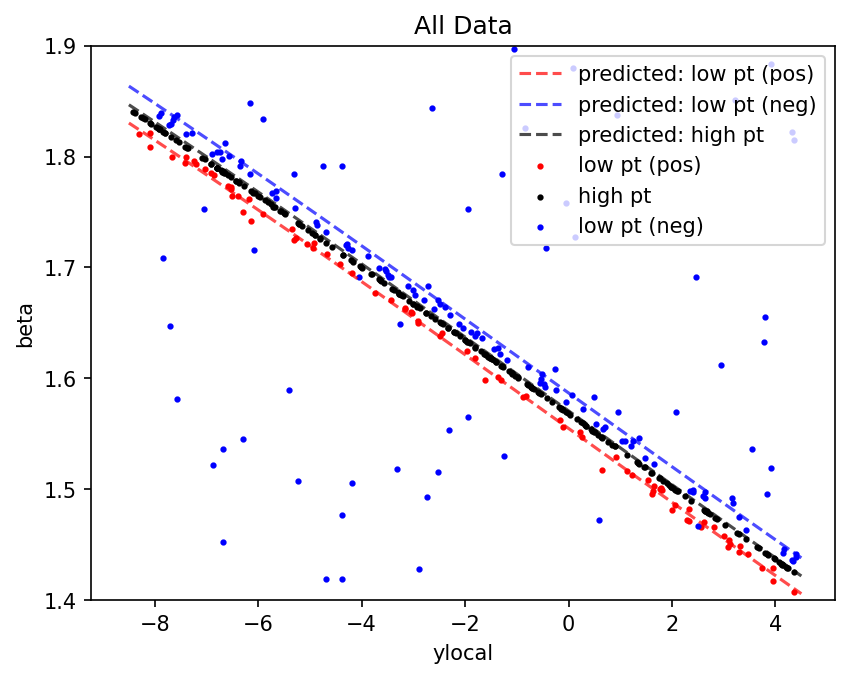

In [10]:
# Plot y local vs pt for high pt
cut = data['pt']<2
cut1 = data['q']<0
cut2 = data['q']>0
cut3 = data['pt']>90
plt.plot(y0, betaLowPos, color='r',linestyle = 'dashed',label='predicted: low pt (pos)',alpha=.7)
plt.plot(y0, betaLowNeg, color='b',linestyle = 'dashed',label='predicted: low pt (neg)',alpha=.7)
plt.plot(y0, betaHigh, color='k',linestyle = 'dashed',label='predicted: high pt',alpha=.7)
plt.scatter(data['ylocal'][cut&cut2], data['beta'][cut&cut2], color='r',s=4, label='low pt (pos)')
plt.scatter(data['ylocal'][cut3], data['beta'][cut3], color='k', s=4, label='high pt')
plt.scatter(data['ylocal'][cut&cut1], data['beta'][cut&cut1], color='b', s=4, label='low pt (neg)')
plt.ylim(1.4, 1.9)
plt.legend()
plt.ylabel('beta')
plt.xlabel('ylocal')
plt.title("All Data")
plt.show()

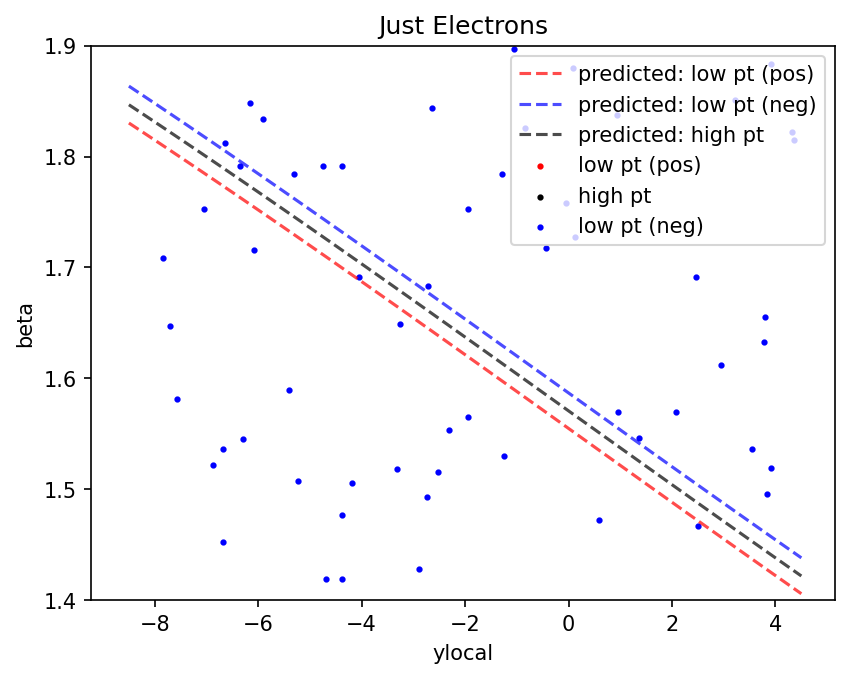

In [11]:
# Plot y local vs pt for high pt
cut = data['pt']<2
cut1 = data['q']<0
cut2 = data['q']>0
cut3 = data['pt']>90
cut4 = data['pid']==11
cut5 = data['pid']==-11
cut4 = cut4 | cut5
plt.plot(y0, betaLowPos, color='r',linestyle = 'dashed',label='predicted: low pt (pos)',alpha=.7)
plt.plot(y0, betaLowNeg, color='b',linestyle = 'dashed',label='predicted: low pt (neg)',alpha=.7)
plt.plot(y0, betaHigh, color='k',linestyle = 'dashed',label='predicted: high pt',alpha=.7)
plt.scatter(data['ylocal'][cut&cut2&cut4], data['beta'][cut&cut2&cut4], color='r',s=4, label='low pt (pos)')
plt.scatter(data['ylocal'][cut3&cut4], data['beta'][cut3&cut4], color='k', s=4, label='high pt')
plt.scatter(data['ylocal'][cut&cut1&cut4], data['beta'][cut&cut1&cut4], color='b', s=4, label='low pt (neg)')
plt.ylim(1.4, 1.9)
plt.legend()
plt.ylabel('beta')
plt.xlabel('ylocal')
plt.title("Just Electrons")
plt.show()

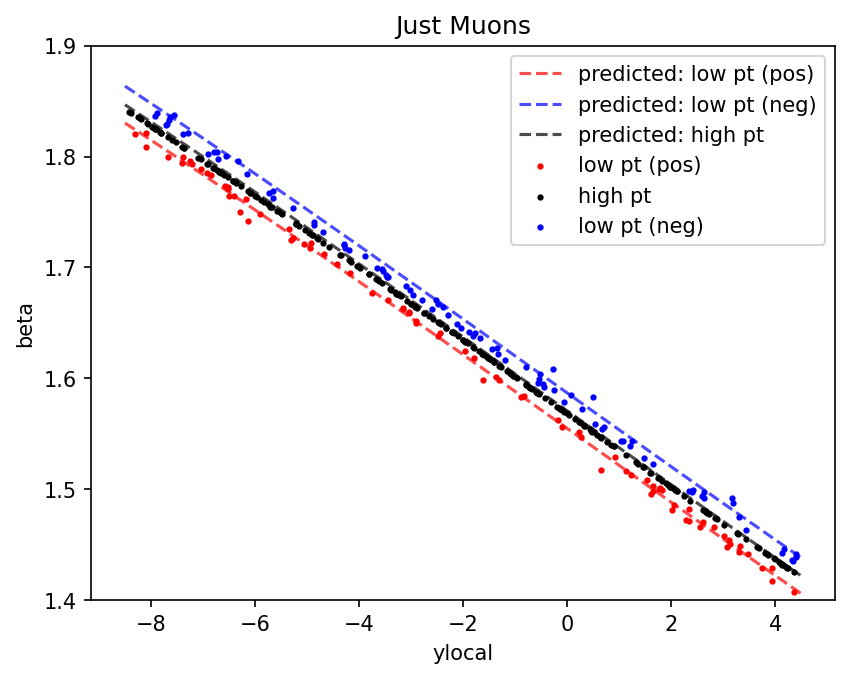

In [12]:
# Plot y local vs pt for high pt
cut = data['pt']<2
cut1 = data['q']<0
cut2 = data['q']>0
cut3 = data['pt']>90
cut4 = data['pid']==13
cut5 = data['pid']==-13
cut4 = cut4 | cut5
plt.plot(y0, betaLowPos, color='r',linestyle = 'dashed',label='predicted: low pt (pos)',alpha=.7)
plt.plot(y0, betaLowNeg, color='b',linestyle = 'dashed',label='predicted: low pt (neg)',alpha=.7)
plt.plot(y0, betaHigh, color='k',linestyle = 'dashed',label='predicted: high pt',alpha=.7)
plt.scatter(data['ylocal'][cut&cut2&cut4], data['beta'][cut&cut2&cut4], color='r',s=4, label='low pt (pos)')
plt.scatter(data['ylocal'][cut3&cut4], data['beta'][cut3&cut4], color='k', s=4, label='high pt')
plt.scatter(data['ylocal'][cut&cut1&cut4], data['beta'][cut&cut1&cut4], color='b', s=4, label='low pt (neg)')
plt.ylim(1.4, 1.9)
plt.legend()
plt.ylabel('beta')
plt.xlabel('ylocal')
plt.title("Just Muons")
plt.show()

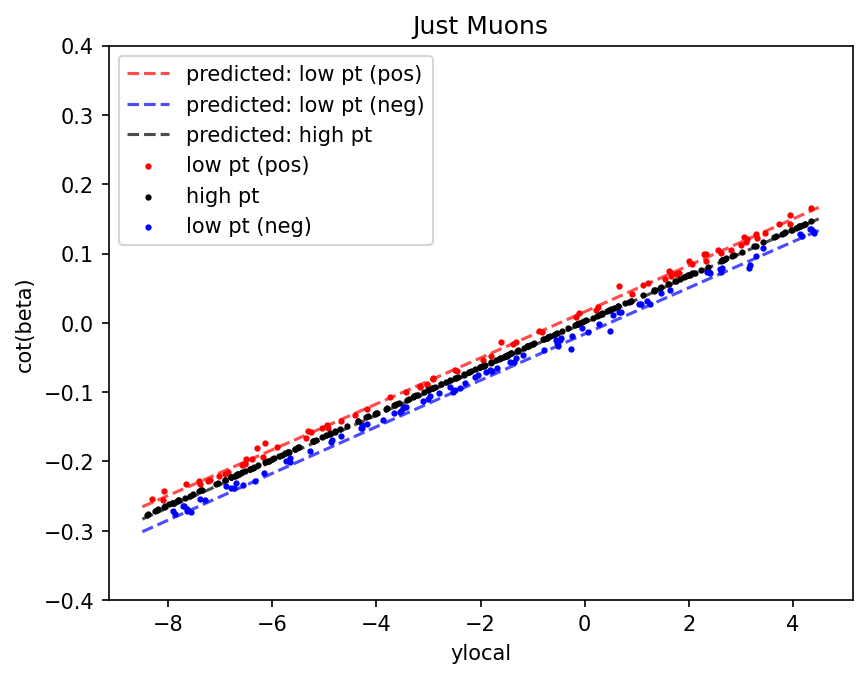

In [13]:
plt.plot(y0, 1/np.tan(betaLowPos), color='r',linestyle = 'dashed',label='predicted: low pt (pos)',alpha=.7)
plt.plot(y0, 1/np.tan(betaLowNeg), color='b',linestyle = 'dashed',label='predicted: low pt (neg)',alpha=.7)
plt.plot(y0, 1/np.tan(betaHigh), color='k',linestyle = 'dashed',label='predicted: high pt',alpha=.7)
plt.scatter(data['ylocal'][cut&cut2&cut4], 1/np.tan(data['beta'][cut&cut2&cut4]), color='r',s=4, label='low pt (pos)')
plt.scatter(data['ylocal'][cut3&cut4], 1/np.tan(data['beta'][cut3&cut4]), color='k', s=4, label='high pt')
plt.scatter(data['ylocal'][cut&cut1&cut4], 1/np.tan(data['beta'][cut&cut1&cut4]), color='b', s=4, label='low pt (neg)')
plt.ylim(-.4, .4)
plt.legend()
plt.ylabel('cot(beta)')
plt.xlabel('ylocal')
plt.title("Just Muons")
plt.show()

In [14]:
data['phiDiff'] = data['phi']-data['phi0']
for i in range(len(data['phiDiff'])):
    while data['phiDiff'][i] > np.pi:
        data.loc[i, 'phiDiff'] -= 2*np.pi
    while data['phiDiff'][i] < -np.pi:
        data.loc[i, 'phiDiff'] += 2*np.pi

In [15]:
for i in range(10):
    print(f"Charge: {data['q'][i]}; phiDiff: {data['phiDiff'][i]}")

Charge: -1.0; phiDiff: 0.0008999999999999009
Charge: -1.0; phiDiff: 0.0009399999999999409
Charge: -1.0; phiDiff: 0.0009399999999999409
Charge: -1.0; phiDiff: 0.0005900000000000072
Charge: 1.0; phiDiff: -0.00036999999999998145
Charge: 1.0; phiDiff: -0.0005699999999999872
Charge: -1.0; phiDiff: 0.0017599999999999838
Charge: 1.0; phiDiff: -0.0016300000000000203
Charge: 1.0; phiDiff: -0.0016300000000000203
Charge: -1.0; phiDiff: 0.0006700000000001705
